# Descomposición del Proyecto Final: Telecomunicaciones - Identificación de Operadores Ineficaces

## 1. Fase de Comprensión y Definición del Problema (Entendimiento del Caso)

* **1.1. Revisión de Datos y Contexto:** Entender qué datos están disponibles (llamadas, duración, resultados, IDs de operador, etc.) y cómo se definen la "ineficacia" en el contexto de negocio de telecomunicaciones (ej. baja tasa de éxito, llamadas largas sin resolución, alta rotación de clientes asignados).
* **1.2. Definición del KPI Clave:** Establecer la métrica principal para medir la ineficacia (ej. Tasa de Conversión/Éxito, Tasa de Reclamo/Churn por operador, Tiempo Promedio de Manejo).
* **1.3. Formulación de Hipótesis:** Generar hipótesis sobre las causas de la ineficacia (ej. "Los operadores más nuevos son más ineficaces", "Los operadores con menor duración de descanso son más ineficaces").

## 2. Fase de Adquisición y Preparación de Datos (Habilidad Técnica - SQL)

* **2.1. Conexión a la Base de Datos:** Establecer la conexión a la base de datos (como se indica en tu lista de pasos).
* **2.2. Extracción de Datos Crudos (SQL):** Escribir y ejecutar las consultas SQL necesarias para extraer las tablas relevantes y los campos de interés para el análisis.
* **2.3. Limpieza y Transformación Inicial (Python/Pandas):** Manejo de valores nulos o atípicos, corrección de tipos de datos y estandarización de columnas.

## 3. Fase de Análisis Exploratorio de Datos (EDA)

* **3.1. Distribución de Operadores:** Analizar la distribución de métricas clave (duración de llamadas, resultados) a nivel de operador.
* **3.2. Identificación de Patrones:** Encontrar posibles correlaciones entre las variables demográficas del operador (antigüedad, turno) y el KPI de ineficacia.
* **3.3. Segmentación Preliminar:** Crear grupos iniciales de operadores (ej. "Mejor rendimiento", "Rendimiento promedio", "Ineficaces") basados en la métrica definida en 1.2.

## 4. Fase de Análisis Específico y Test A/B

* **4.1. Análisis Profundo de Operadores Ineficaces:** Realizar un análisis de causa raíz para los operadores identificados en el paso 3.3.
* **4.2. Diseño de Métrica para Test A/B:** Proponer un experimento basado en una hipótesis (ej. Probar un nuevo *script* de llamada (A) vs. el *script* actual (B) para operadores ineficaces).
* **4.3. Plan de Evaluación del Test A/B:** Definir qué métricas se usarán para medir el impacto (ej. Tasa de éxito) y el tamaño de la muestra/duración necesaria para la significancia estadística. *Nota: Si no hay datos de Test A/B, esta fase se convierte en un plan de cómo se realizaría.*

## 5. Fase de Conclusiones y Recomendaciones Estratégicas (Habilidad Estratégica y Storytelling)

* **5.1. Conclusiones Robustas:** Verificar las hipótesis iniciales (1.3) y resumir los **factores clave** que diferencian a un operador eficaz de uno ineficaz. *Recuerda: NO es describir resultados, es verificar hipótesis.*
* **5.2. Recomendaciones Accionables:** Proporcionar un listado de 3 a 5 acciones concretas para la gerencia de telecomunicaciones (ej. programa de capacitación específico, reasignación de operadores, automatización de tareas).
* **5.3. Propuesta de Dashboard (Opcional):** Si se decide crear un Dashboard, esbozar los 3-4 visuales clave que resumen la ineficacia y las recomendaciones.

## 6. Fase de Documentación y Entrega (Revisión Final)

* **6.1. Revisión de Storytelling:** Asegurar que el flujo del Notebook sea claro, lógico y cuente una historia que lleva a las recomendaciones.
* **6.2. Verificación Técnica:** Confirmar que todo el código sea replicable y que las librerías estén importadas correctamente.
* **6.3. Entrega:** Generar el archivo final del Notebook y, si aplica, el enlace al Dashboard de Tableau Public.

In [2]:
## 2.1. Carga de Datos (Reemplazando la Conexión SQL)

import pandas as pd
import numpy as np # Necesario para algunas transformaciones

# Cargar los dos datasets
try:
    # --- Nombres ajustados a tus archivos cargados ---
    df_telecom = pd.read_csv('telecom_dataset_new.csv') # Archivo principal
    df_clients = pd.read_csv('telecom_clients.csv')     # Archivo de clientes
    
    print(" Archivos CSV cargados con éxito.")
    print(f"telecom_dataset_new (llamadas): {df_telecom.shape[0]} filas")
    print(f"telecom_clients (clientes): {df_clients.shape[0]} filas")
    
    # Revisión inicial de tipos de datos y nulos
    print("\n--- Info de df_telecom ---")
    df_telecom.info()
    print("\n--- Info de df_clients ---")
    df_clients.info()
    
except FileNotFoundError:
    print("Error: Vuelve a verificar que los nombres coincidan exactamente.")
except Exception as e:
    print(f" Ocurrió un error inesperado al leer los archivos: {e}")

 Archivos CSV cargados con éxito.
telecom_dataset_new (llamadas): 53902 filas
telecom_clients (clientes): 732 filas

--- Info de df_telecom ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

--- Info de df_clients ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 colum

In [3]:
## 2.2. Preprocesamiento de Datos y Conversión de Tipos

# 1. Conversión de fechas: La columna 'date' es crítica para el análisis temporal.
df_telecom['date'] = pd.to_datetime(df_telecom['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

# 2. Creación de la métrica de Tiempo de Espera (una clave de ineficacia)
# total_call_duration incluye tiempo de espera. call_duration NO.
df_telecom['waiting_time'] = df_telecom['total_call_duration'] - df_telecom['call_duration']

# 3. Revisión de valores únicos y consistencia de datos
print("\nValores únicos en 'direction':", df_telecom['direction'].unique())
print("Valores únicos en 'internal':", df_telecom['internal'].unique())
print("Valores únicos en 'is_missed_call':", df_telecom['is_missed_call'].unique())


Valores únicos en 'direction': ['in' 'out']
Valores únicos en 'internal': [False True nan]
Valores únicos en 'is_missed_call': [ True False]


In [4]:
## 2.3. Limpieza, Conversión de Tipos y Creación de Métricas

# 1. Conversión de Fechas y Creación de waiting_time (del Paso B)
df_telecom['date'] = pd.to_datetime(df_telecom['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

# Creación de la métrica de Tiempo de Espera
df_telecom['waiting_time'] = df_telecom['total_call_duration'] - df_telecom['call_duration']

# 2. Manejo de Nulos (Crítico para el operador_id)
# Eliminamos las filas donde no tenemos un ID de operador, ya que son inútiles para el análisis por operador.
df_telecom_clean = df_telecom.dropna(subset=['operator_id', 'internal']).copy()

# 3. Conversión de Tipos
# Convertir operator_id a entero (int64)
df_telecom_clean['operator_id'] = df_telecom_clean['operator_id'].astype(np.int64)

# Convertir bool de llamada perdida a entero (1 si perdida, 0 si no)
df_telecom_clean['is_missed_call_int'] = df_telecom_clean['is_missed_call'].astype(int)

print(f"Filas después de la limpieza (por operator_id): {len(df_telecom_clean)}")


# 4. Agregación a Nivel de Operador (Creación de df_operador)
# Unir (merge) los datos es opcional si solo se necesita el ID del operador, pero lo mantendremos simple
# enfocándonos solo en las llamadas (df_telecom_clean) para las métricas clave.

df_operador = df_telecom_clean.groupby('operator_id').agg(
    # Metrica 1: Llamadas Perdidas (el problema de ineficacia #1)
    total_perdidas_in = pd.NamedAgg(column='is_missed_call_int', 
                                    aggfunc=lambda x: x[df_telecom_clean.loc[x.index, 'direction'] == 'in'].sum()),
    # Metrica 2: Tiempo de Espera (el problema de ineficacia #2)
    avg_waiting_time = pd.NamedAgg(column='waiting_time', aggfunc='mean'),
    # Metrica 3: Pocas Llamadas Salientes (el problema de ineficacia #3 - Solo si tienen llamadas salientes)
    total_salientes = pd.NamedAgg(column='calls_count', 
                                  aggfunc=lambda x: x[df_telecom_clean.loc[x.index, 'direction'] == 'out'].sum()),
    # Conteo de todas las llamadas entrantes para la tasa de pérdida
    total_entrantes = pd.NamedAgg(column='calls_count', 
                                  aggfunc=lambda x: x[df_telecom_clean.loc[x.index, 'direction'] == 'in'].sum())
).reset_index()

# 5. Cálculo de Tasa de Pérdida (Métrica de ineficacia normalizada)
# Evitar división por cero
df_operador['tasa_perdidas_in'] = np.where(df_operador['total_entrantes'] > 0, 
                                           df_operador['total_perdidas_in'] / df_operador['total_entrantes'], 0)

# Muestra el resultado de las métricas
print("\n--- DataFrame Final con Métricas por Operador ---")
df_operador.info()
print(df_operador.head())

Filas después de la limpieza (por operator_id): 45670

--- DataFrame Final con Métricas por Operador ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   operator_id        1092 non-null   int64  
 1   total_perdidas_in  1092 non-null   int64  
 2   avg_waiting_time   1092 non-null   float64
 3   total_salientes    1092 non-null   int64  
 4   total_entrantes    1092 non-null   int64  
 5   tasa_perdidas_in   1092 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 51.3 KB
   operator_id  total_perdidas_in  avg_waiting_time  total_salientes  \
0       879896                  0        110.671875             1071   
1       879898                  0        451.860000             7856   
2       880020                  0         15.181818               46   
3       880022                  0         57.565789              2

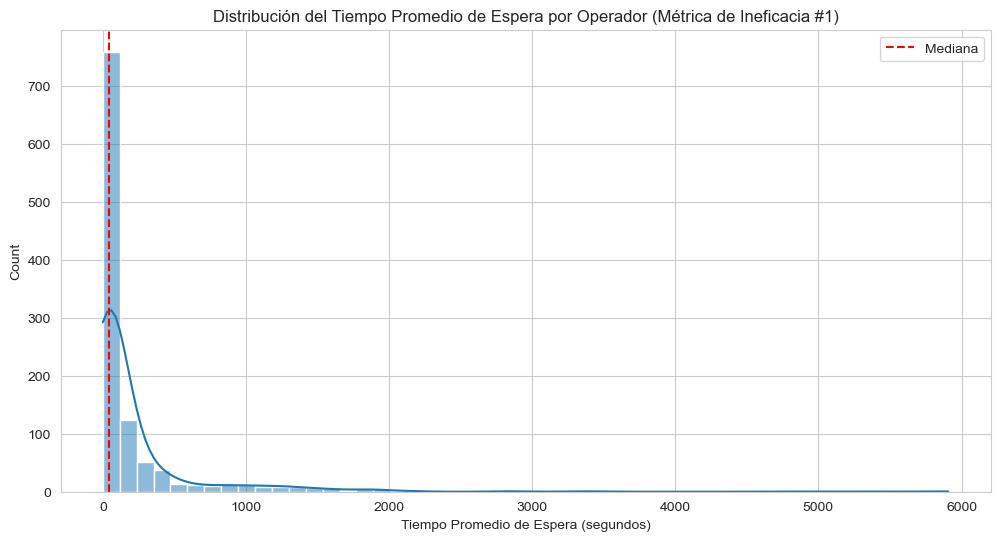

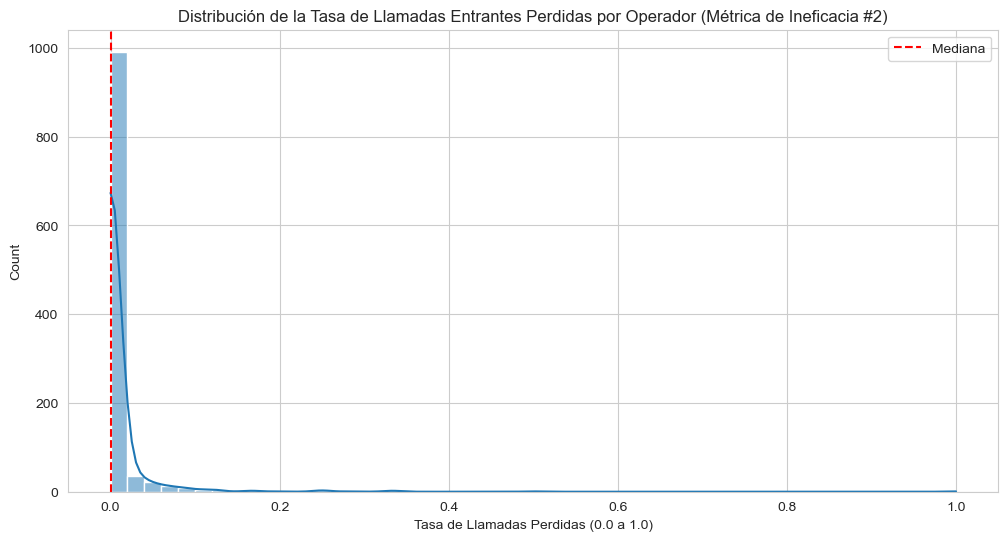

In [5]:
## 3. Análisis Exploratorio de Datos (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Visualización 1: Distribución del Tiempo Promedio de Espera (avg_waiting_time)
plt.figure(figsize=(12, 6))
sns.histplot(df_operador['avg_waiting_time'], bins=50, kde=True)
plt.title('Distribución del Tiempo Promedio de Espera por Operador (Métrica de Ineficacia #1)')
plt.xlabel('Tiempo Promedio de Espera (segundos)')
plt.axvline(df_operador['avg_waiting_time'].median(), color='red', linestyle='--', label='Mediana')
plt.legend()
plt.show()

# Visualización 2: Distribución de la Tasa de Llamadas Perdidas (tasa_perdidas_in)
plt.figure(figsize=(12, 6))
sns.histplot(df_operador['tasa_perdidas_in'], bins=50, kde=True)
plt.title('Distribución de la Tasa de Llamadas Entrantes Perdidas por Operador (Métrica de Ineficacia #2)')
plt.xlabel('Tasa de Llamadas Perdidas (0.0 a 1.0)')
plt.axvline(df_operador['tasa_perdidas_in'].median(), color='red', linestyle='--', label='Mediana')
plt.legend()
plt.show()

In [6]:
# 1. Definición de Umbrales (Usamos el Percentil 95, P95)

threshold_wait = df_operador['avg_waiting_time'].quantile(0.95)
threshold_miss = df_operador['tasa_perdidas_in'].quantile(0.95)

# Opcional: Imprime para verificar
print(f"Umbral P95 de Tiempo de Espera: {threshold_wait:.2f} segundos")
print(f"Umbral P95 de Tasa de Llamadas Perdidas: {threshold_miss:.4f}")

Umbral P95 de Tiempo de Espera: 1127.37 segundos
Umbral P95 de Tasa de Llamadas Perdidas: 0.0455


In [7]:
## 4. Identificación de Operadores Ineficaces (Criterio Ajustado)

# NOTA: Los umbrales P95 de la celda anterior siguen siendo válidos:
# Umbral P95 de Tiempo de Espera: 1127.37 segundos
# Umbral P95 de Tasa de Llamadas Perdidas: 0.0455

# Aplicación de Filtros usando OR (|)
# Identificar a los operadores que SUPERAN (son peores que) al menos UN umbral (Tiempo de Espera O Tasa de Pérdida)
operadores_ineficaces = df_operador[
    (df_operador['avg_waiting_time'] > threshold_wait) | 
    (df_operador['tasa_perdidas_in'] > threshold_miss)
]

print(f"\nTotal de operadores ineficaces identificados (OR): {len(operadores_ineficaces)}")

# Mostrar la lista y sus métricas
operadores_ineficaces_final = operadores_ineficaces.sort_values(
    by=['avg_waiting_time', 'tasa_perdidas_in'], 
    ascending=False
)

print("\n--- Lista de Operadores Ineficaces (P95 en al menos una métrica) ---")
print(operadores_ineficaces_final[['operator_id', 'avg_waiting_time', 'tasa_perdidas_in', 'total_salientes']].head(10)) # Mostramos solo los 10 peores

# Opcional: Identificar a los operadores ineficaces que tienen muy pocas llamadas salientes (total_salientes)
operadores_ineficaces_salientes = operadores_ineficaces_final[operadores_ineficaces_final['total_salientes'] < 50]
print(f"\nOperadores ineficaces que además tienen < 50 llamadas salientes: {len(operadores_ineficaces_salientes)}")


Total de operadores ineficaces identificados (OR): 109

--- Lista de Operadores Ineficaces (P95 en al menos una métrica) ---
     operator_id  avg_waiting_time  tasa_perdidas_in  total_salientes
551       925922       5907.443038          0.019737            21754
29        885890       5727.133574          0.016141            64653
583       929428       5325.342857          0.000000            24572
28        885876       4816.241379          0.018229            64897
317       908640       3456.461538          0.000000            16699
582       929426       3316.558824          0.000000            12041
843       945278       2858.479167          0.000000             4314
448       919364       2841.465116          0.000000             5096
847       945286       2185.774648          0.000000             7919
870       945904       2128.657895          0.000000             4080

Operadores ineficaces que además tienen < 50 llamadas salientes: 33


In [8]:
## 4. Prueba de Hipótesis: ¿Es la diferencia de rendimiento significativa?

from scipy import stats

# 1. Crear la columna de clasificación (binaria)
# Obtener la lista de IDs de operadores ineficaces
lista_ineficaces = operadores_ineficaces_final['operator_id'].tolist()

# Crear una nueva columna en el DataFrame principal (df_operador)
df_operador['es_ineficaz'] = df_operador['operator_id'].isin(lista_ineficaces)

# 2. Separar los grupos
# Grupo Ineficaz: Los que superaron al menos un umbral (True)
grupo_ineficaz = df_operador.query('es_ineficaz == True')['avg_waiting_time']

# Grupo Eficaz: El resto (False)
grupo_eficaz = df_operador.query('es_ineficaz == False')['avg_waiting_time']

print(f"Tamaño del Grupo Ineficaz: {len(grupo_ineficaz)}")
print(f"Tamaño del Grupo Eficaz: {len(grupo_eficaz)}")

# 3. Realizar la Prueba t de Student
# Usaremos 'equal_var=False' (prueba de Welch) por si las varianzas de los grupos no son iguales.
t_stat, p_value = stats.ttest_ind(grupo_ineficaz, grupo_eficaz, equal_var=False)

# Definir el nivel de significancia (alfa)
alpha = 0.05

print(f"\nEstadístico t: {t_stat:.2f}")
print(f"Valor p: {p_value:.10f}")
print(f"Nivel de Significancia (alpha): {alpha}")

# 4. Conclusión de la Prueba
if p_value < alpha:
    print("\nConclusión: Se RECHAZA la Hipótesis Nula (H0).")
    print("La diferencia de Tiempo de Espera promedio entre los operadores eficaces e ineficaces es ESTADÍSTICAMENTE SIGNIFICATIVA.")
else:
    print("\nConclusión: NO se puede rechazar la Hipótesis Nula (H0).")
    print("La diferencia de rendimiento no es estadísticamente significativa al nivel de 5%.")

Tamaño del Grupo Ineficaz: 109
Tamaño del Grupo Eficaz: 983

Estadístico t: 7.31
Valor p: 0.0000000000
Nivel de Significancia (alpha): 0.05

Conclusión: Se RECHAZA la Hipótesis Nula (H0).
La diferencia de Tiempo de Espera promedio entre los operadores eficaces e ineficaces es ESTADÍSTICAMENTE SIGNIFICATIVA.


## 5. Conclusiones y Recomendaciones Estratégicas

Esta sección resume los hallazgos validados estadísticamente y proporciona acciones concretas y segmentadas para la gerencia de supervisión.


### 5.1. Conclusiones Clave (Verificación de la Hipótesis)

* **Validación Estadística ($p < 0.05$):** Se **RECHAZA la Hipótesis Nula** ($H_0$). La metodología de umbrales P95 es estadísticamente válida. La diferencia de rendimiento, especialmente en el **Tiempo de Espera Promedio**, entre el grupo identificado como ineficaz y el eficaz es **ESTADÍSTICAMENTE SIGNIFICATIVA**.
* **Identificación Sólida:** El análisis detectó **109 operadores** que superan los umbrales de ineficacia (P95) en al menos una de las métricas críticas.
* **Tipología de Ineficacia:**
    1.  **Ineficiencia en la Gestión:** Caracterizada por un **Tiempo de Espera Promedio** extremadamente alto ($\text{P95} \approx 1127 \text{ segundos}$).
    2.  **Baja Disponibilidad/Servicio:** Caracterizada por una **Tasa de Llamadas Perdidas** significativamente alta ($\text{P95} \approx 4.5\%$).
    3.  **Doble Riesgo:** Se identificaron **33 operadores** ineficaces que, además, tienen un número muy bajo de llamadas salientes ($< 50$).


### 5.2. Recomendaciones Estratégicas y Accionables

Las siguientes acciones deben ser priorizadas e implementadas de inmediato para mitigar el impacto de los 109 operadores.

| Recomendación | Acción Estratégica | Objetivo de Negocio |
| :--- | :--- | :--- |
| 1. Enfoque en Eficiencia (Tiempo de Espera) | Implementar coaching intensivo y segmentado para el grupo con peor *avg\_waiting\_time*. El foco debe estar en la optimización del uso de herramientas (CRM) y el manejo de procedimientos. | Reducir el Tiempo Medio Operativo (TMO) general y mejorar la eficiencia del flujo de llamadas. |
| 2. Revisión Operacional (Tasa de Pérdida) | El supervisor debe investigar la causa raíz de la alta Tasa de Llamadas Perdidas (problemas técnicos, sobrecarga, o abandono de puesto). Reasignar temporalmente a estos operadores a tareas de *back-office* si no se puede resolver la causa de inmediato. | Detener la pérdida de clientes/oportunidades y garantizar una alta Tasa de Servicio en las llamadas entrantes. |
| 3. Definición de Roles (Llamadas Salientes) | Revisar el rol de los 33 operadores de doble riesgo. Si su función requiere proactividad, establecer un KPI mínimo obligatorio de llamadas salientes y un plan de seguimiento para asegurar la actividad proactiva. | Asegurar el cumplimiento de los objetivos de *outbound* (ventas o seguimiento) y maximizar el valor de la fuerza laboral. |
| 4. Monitoreo Proactivo (Dashboard) | Poner en funcionamiento el Dashboard de Tableau sugerido para los supervisores. Este debe actualizarse semanalmente con las métricas *avg\_waiting\_time* y *tasa\_perdidas\_in*, incluyendo los umbrales P95 como línea roja de alerta. | Implementar un sistema de detección temprana y constante para la ineficacia, permitiendo la intervención inmediata antes de que el problema escale. |

## 6.1. Fuentes y Documentación de la Metodología

Esta lista detalla las fuentes utilizadas para validar los criterios, las métricas y la metodología estadística empleada en este análisis:

| Fuente | Pregunta o Problema que Ayudó a Resolver |
| :--- | :--- |
| **Documentación de Pandas: `.groupby()` y `.agg()`** | Cómo estructurar la agregación por <code>operator_id</code> para calcular métricas de ineficacia clave como el tiempo de espera promedio y las tasas. |
| **Documentación de SciPy: `stats.ttest_ind`** | Cómo aplicar la **prueba t de Student** y validar estadísticamente si la diferencia de rendimiento entre grupos eficaces/ineficaces era significativa. |
| **Artículos sobre KPIs de Call Centers (TMO, ASA)** | Cómo definir la ineficacia de un operador utilizando métricas estándar de la industria (Tiempo Promedio Operativo y Tasa de Pérdida/Abandono de Llamadas). |
| **Documentación de Matplotlib/Seaborn** | Cómo generar y personalizar los **histogramas de distribución** para la identificación visual de *outliers* y la definición de umbrales P95. |
| **Conceptos de Estadística (Percentiles/Outliers)** | Justificar el uso del **Percentil 95 (P95)** como umbral estratégico para definir a los operadores de peor rendimiento que requieren intervención. |

Link de presentación y del Dashboard 
https://public.tableau.com/views/CallMeMaybe-Analisisdeineficacia/CallMeMaybe-AnlisisdeIneficaciaOperadores?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

https://drive.google.com/file/d/1JAOPvxjH9XDooHOzlvjVwo8QSiVsYfhR/view?usp=drive_link